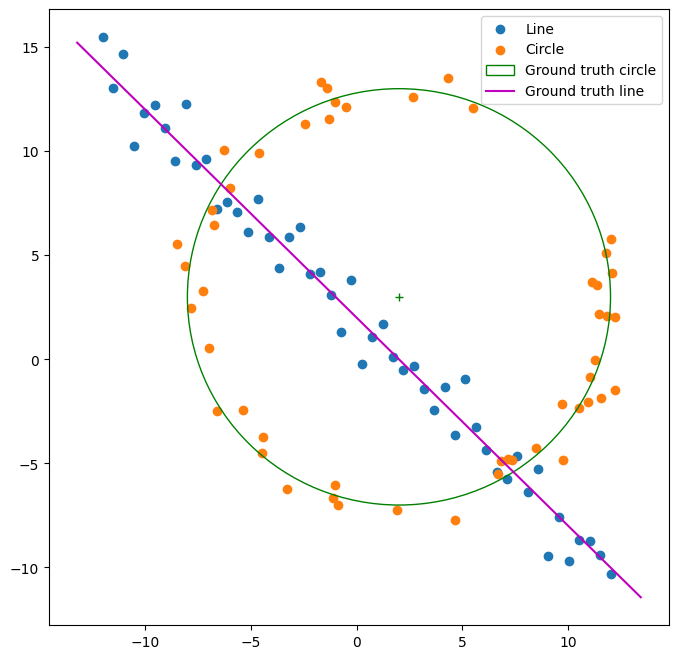

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib
import math

# Set random seed (optional)
# np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()

# Optionally save the plot as a TikZ file
# tikzplotlib.save("plot.tex")

plt.show()



Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.855811006717603e-09
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3959136432881349e-08
            Iterations: 8
            Function evaluations: 37
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.961930184136993e-08
            Iterations: 9
            Function evaluations: 40
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.434435213334478e-08
            Iterations: 7
            Function evaluations: 33
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.5765551321936927e-10
            Iterations: 8
            Func

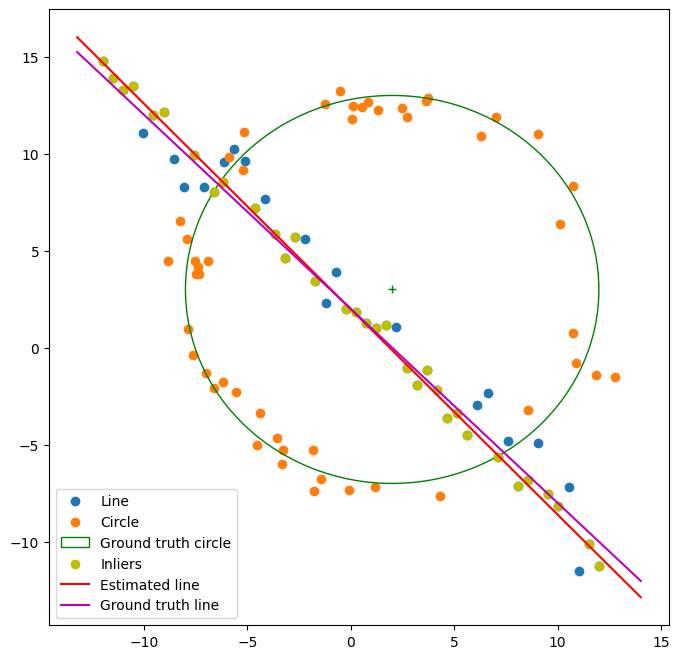

In [187]:
N=X.shape[0]
X_=X
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    # Return the line equation in the form ax + by = d
    return a, b, d

# RANSAC to fit a line
def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))

# Constraint
def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

# Computing the consensus (inliers)
def consensus_line(X_, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t

# ...

def ransac_line(X, t, iter, in_t):
    n = X.shape[0]
    best_error = np.inf
    best_sample_line = []    # Three-point sample leading to the best model computation
    res_only_with_sample = [] # Result (a, b, d) only using the best sample
    best_inliers_line = []   #

    for i in range(iter):
        # Randomly sample 2 points
        indices = np.random.choice(n, 2, replace=False)
        x0 = [1, 1, 0]
        res = minimize(fun=line_tls, args=indices, x0=x0, tol=1e-6, constraints=cons, options={'disp': True})
        # Compute consensus
        inliers = consensus_line(X, res.x, t)  # Use res.x here instead of res.X
        # Compute number of inliers
        n_inliers = np.sum(inliers)
        if n_inliers > in_t:
            x0 = res.x
            res = minimize(fun=line_tls, args=inliers, x0=x0, tol=1e-6, constraints=cons, options={'disp': True})
            if res.fun < best_error:
                best_error = res.fun
                best_inliers_line = inliers
                best_a, best_b, best_d = res.x
                best_sample_line = indices
                print(indices)
                res_only_with_sample = x0

    return best_a, best_b, best_d, best_inliers_line, best_sample_line, res_only_with_sample



best_a, best_b, best_d, best_inliers_line, best_sample_line, res_only_with_sample = ransac_line(X, 0.63, 500, 0.32 * X.shape[0])
print(best_inliers_line.shape)


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')
ax.scatter(X[best_inliers_line,0],X[best_inliers_line,1], color='y', label='Inliers')
#ax.scatter(best_sample_line[0],best_sample_line[1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_est = (-best_a/best_b)*x_ + best_d/best_b
plt.plot(x_, y_est, color='r', label='Estimated line')
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()


Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.004306696283379e-06
            Iterations: 45
            Function evaluations: 240
            Gradient evaluations: 45
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.828614187715516e-05
            Iterations: 21
            Function evaluations: 114
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.007692616390201579
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.266464052690935e-07
            Iterations: 29
            Function evaluations: 157
            Gradient evaluations: 29
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.5640956757323465e-05
            Iterations: 39
      

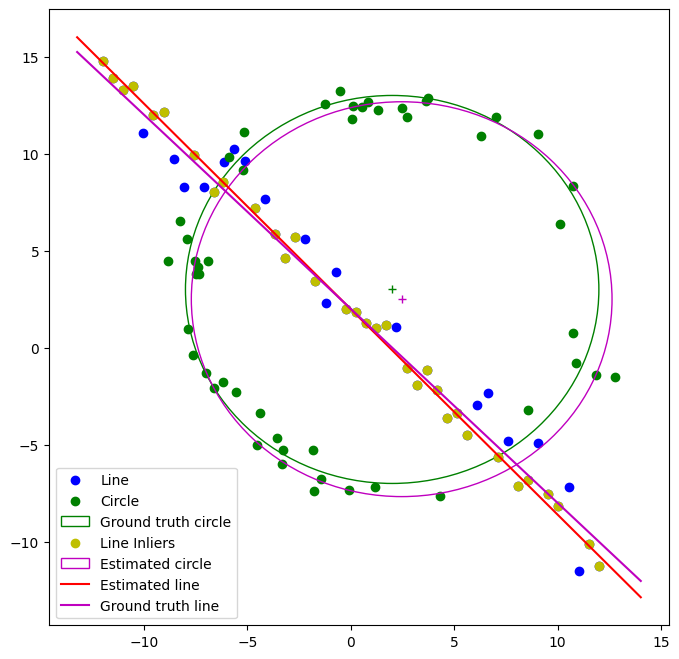

In [208]:
#all_indices = np.arange(len(X))
#remaining_indices = np.setdiff1d(all_indices, best_inliers_line)
remaining_points=X
if best_inliers_line is not None:
    remaining_points= remaining_points[best_inliers_line, :]



def circle_consensus(data, model,t):
    # Calculate the Euclidean distance between data points and the circle's center
    center_x, center_y, radius = model
    distances = np.sqrt((data[:, 0] - center_x)**2 + (data[:, 1] - center_y)**2)
    
    # Check if the distances are within the threshold_inside for inside points
    inliers = np.abs(distances - radius) < t
    
    return inliers



def circle_tls(x, indices, remaining_points):
    x_center, y_center, r = x[0], x[1], x[2]
    # Calculate the squared differences between the distances and the circle's radius
    squared_errors = np.sqrt((remaining_points[indices, 0] - x_center)**2 + (remaining_points[indices, 1] - y_center)**2 )
    # Return the sum of squared errors
    return np.sum(np.abs(squared_errors-r))

distance_treshold=0.4
con_c={'type': 'ineq', 'fun': lambda x: x[2] - distance_treshold}
def ransac_circle(X, t, iter, in_t):
    n = X.shape[0]
    best_error = np.inf
    best_sample_circle = []    # Three-point sample leading to the best model computation
    res_only_with_sample = [] # Result (a, b, d) only using the best sample
    best_inliers_circle = []   #

    for i in range(iter):
        # Randomly sample 3 points
        indices = np.random.choice(n, 3, replace=False)
        x0 = [1, 1, 1]
        res = minimize(fun=circle_tls, args=(indices,X), x0=x0, tol=1e-6, constraints=con_c, options={'disp': True})
        # Compute consensus
        inliers = circle_consensus(X, res.x, t)  # Use res.x here instead of res.X
        # Compute number of inliers
        n_inliers = np.sum(inliers)
        if n_inliers > in_t:
            x0 = res.x
            res = minimize(fun=circle_tls, args=(inliers,X), x0=x0, tol=1e-6, constraints=con_c, options={'disp': True})
            if res.fun < best_error:
                best_error = res.fun
                best_inliers_circle = inliers
                best_x_center, best_y_center, best_r = res.x
                best_sample_circle = indices
                print(indices)
                res_only_with_sample = x0

    return best_x_center, best_y_center, best_r, best_inliers_circle, best_sample_circle, res_only_with_sample



best_x_center, best_y_center, best_r, best_inliers_circle, best_sample_circle, res_only_with_sample = ransac_circle(remaining_points, distance_treshold, 1000, 0.7 * remaining_points.shape[0])
print(best_x_center, best_y_center, best_r)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for points
ax.scatter(X_line[:, 0], X_line[:, 1], color='b', label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], color='g', label='Circle')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

# Inliers for line
ax.scatter(X[best_inliers_line, 0], X[best_inliers_line, 1], color='y', label='Line Inliers')

# Inliers for circle
#ax.scatter(remaining_points[best_inliers_circle, 0], remaining_points[best_inliers_circle, 1], color='r', label='Circle Inliers')

# Estimated circle
circle_est = plt.Circle((best_x_center, best_y_center), best_r, color='m', fill=False, label='Estimated circle')

ax.add_patch(circle_est)
ax.plot(best_x_center, best_y_center, '+', color='m')

# Estimated line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_est = (-best_a / best_b) * x_ + best_d / best_b
plt.plot(x_, y_est, color='r', label='Estimated line')

# Ground truth line
plt.plot(x_, y_, color='m', label='Ground truth line')

# Legend
plt.legend()
plt.show()


2.460203590028309 2.49840005790853 10.176519576385566


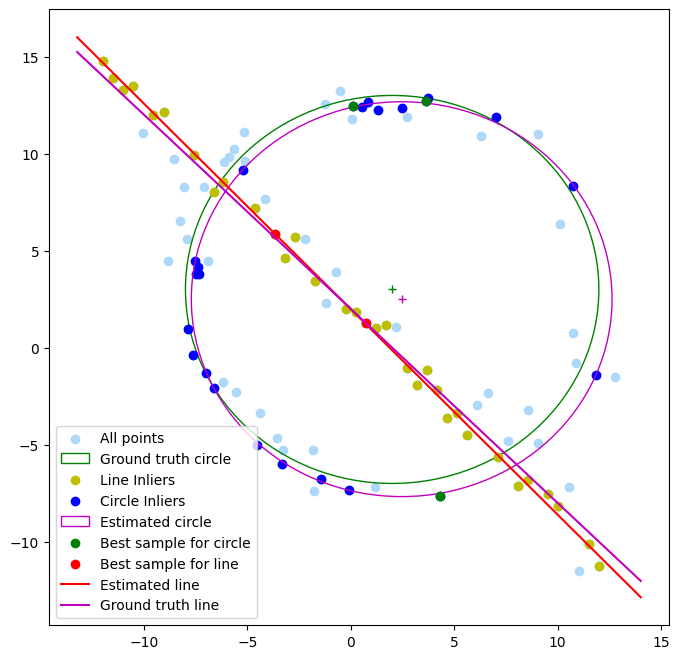

In [215]:
print(best_x_center, best_y_center, best_r)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
light_blue = (173/255, 216/255, 250/255)
# Scatter plot for points
ax.scatter(X[:, 0], X[:, 1], color=light_blue, label='All points')


# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

# Inliers for line
ax.scatter(X[best_inliers_line, 0], X[best_inliers_line, 1], color='y', label='Line Inliers')
ax.scatter(X_circ[best_inliers_circle, 0], X_circ[best_inliers_circle, 1], color='b', label='Circle Inliers')
# Inliers for circle
#ax.scatter(remaining_points[best_inliers_circle, 0], remaining_points[best_inliers_circle, 1], color='r', label='Circle Inliers')

# Estimated circle
circle_est = plt.Circle((best_x_center, best_y_center), best_r, color='m', fill=False, label='Estimated circle')

ax.add_patch(circle_est)
ax.plot(best_x_center, best_y_center, '+', color='m')
#plot best sample for circle in orange
ax.scatter(X_circ[best_sample_circle, 0], X_circ[best_sample_circle, 1], color='g', label='Best sample for circle')
#plot best sample for line in red
ax.scatter(X[best_sample_line, 0], X[best_sample_line, 1], color='r', label='Best sample for line')
# Estimated line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_est = (-best_a / best_b) * x_ + best_d / best_b
plt.plot(x_, y_est, color='r', label='Estimated line')

# Ground truth line
plt.plot(x_, y_, color='m', label='Ground truth line')
# Legend
plt.legend()
plt.show()

In [196]:
print(remaining_points.shape)
print(best_inliers_circle.shape)
print(best_inliers_line)

(33, 2)
(50,)
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False  True  True  True  True False  True  True False False  True
 False  True False False False  True False  True  True  True False  True
 False False  True  True  True  True  True False  True  True  True  True
  True  True  True False False  True False  True  True False  True  True
 False False  True  True]


In [68]:
# Create a list to store selected corner points
import cv2 as cv
corner_points = []

def click_event(event, x, y, flags, param):
    global corner_points

    # If the left mouse button is clicked, record the coordinates
    if event == cv.EVENT_LBUTTONDOWN:
        corner_points.append((x, y))
        cv.circle(background_image, (x, y), 5, (0, 0, 255), -1)  # Draw a red circle at the clicked point
        cv.imshow('Image',background_image)

        # If all four corners are selected, stop capturing clicks
        if len(corner_points) == 4:
            cv.destroyAllWindows()

# Load your image here
img=cv.cvtColor(cv.imread('Screenshot 2023-09-30 185402.png'), cv.COLOR_BGR2RGB)

background_image = cv.imread('Screenshot 2023-09-30 185402.png')
#background_image_orig = cv.cvtColor(cv.imread('Screenshot 2023-09-30 185402.png'), cv.COLOR_BGR2RGB)
# Display the image and set a mouse callback function
cv.imshow('Image', background_image)
cv.setMouseCallback('Image', click_event)

# Wait for user interaction
cv.waitKey(0)

# Print the selected corner points
print("Selected Corner Points:")
for point in corner_points:
    print(point)

# Load the background image (architectural image)




Selected Corner Points:
(34, 39)
(32, 99)
(114, 103)
(114, 55)


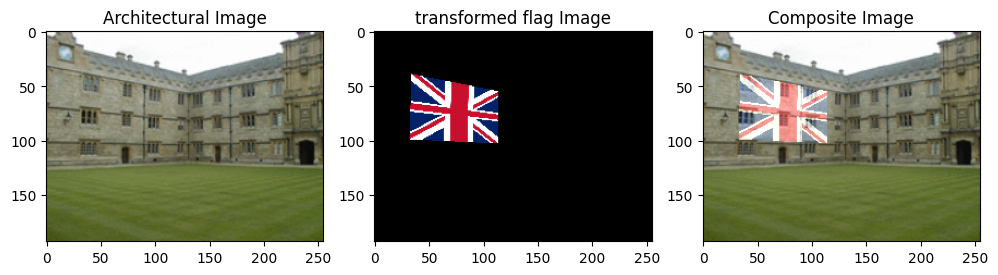

In [69]:

img1=cv.imread('Screenshot 2023-09-30 185402.png')
# Load the architectural image and flag image

flag_image = cv.imread('Flag_of_the_United_Kingdom_(1-2).svg.png')

# Define the corresponding points in the architectural image and flag image
pts_architecture = np.array(corner_points, dtype=np.float32)
pts_flag = np.array([[0, 0], [flag_image.shape[1], 0], [flag_image.shape[1], flag_image.shape[0]], [0, flag_image.shape[0]]], dtype=np.float32)

# Calculate the homography matrix
homography_matrix, _ = cv.findHomography(pts_flag, pts_architecture)

# Warp the flag image
flag_warped = cv.warpPerspective(flag_image, homography_matrix, (background_image.shape[1], background_image.shape[0]))
flag=cv.cvtColor(flag_warped, cv.COLOR_BGR2RGB)
# Blend the images (alpha blending)
alpha = 0.5 # Adjust transparency as needed

composite_image = cv.addWeighted(img1, 1, flag_warped, alpha, 0, dst=background_image)
composite=cv.cvtColor(composite_image, cv.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Architectural Image')
plt.subplot(1, 3, 2)
plt.imshow(flag)
plt.title('transformed flag Image')
# Display the composite image
plt.subplot(1, 3, 3)
plt.imshow(composite)
plt.title('Composite Image')
plt.tight_layout()
plt.show()


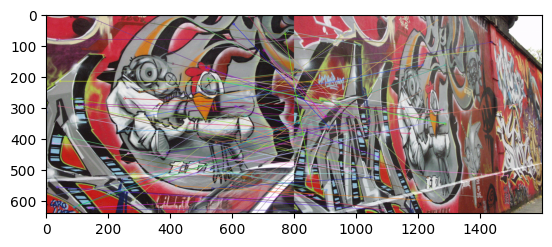

(<matplotlib.image.AxesImage at 0x1eee8aa3710>, None)

In [70]:
img1 = cv.imread('img1.ppm')
img5 = cv.imread('img5.ppm')
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp5, des5 = sift.detectAndCompute(img5, None)
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des5, k=2)
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)
img3 = cv.drawMatchesKnn(img1, kp1, img5, kp5, [good], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img3=cv.cvtColor(img3, cv.COLOR_BGR2RGB)
plt.imshow(img3), plt.show()





6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00

Computed Homography =  [[ 6.44955144e-01  6.12157410e-02  2.20782077e+02]
 [ 2.39655712e-01  1.18359710e+00 -3.39064195e+01]
 [ 5.28631961e-04 -4.03146654e-05  1.00000000e+00]]


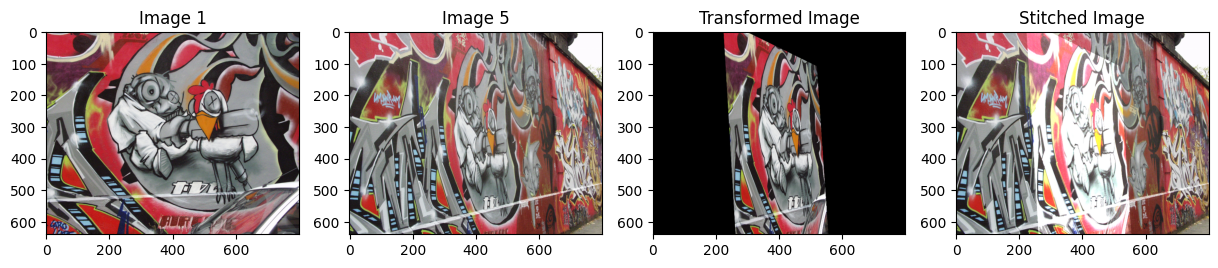

In [86]:
from random import randint
img2, img3, img4, img1, img5 = cv.imread("img2.ppm"), cv.imread("img3.ppm"), cv.imread("img4.ppm"), cv.imread("img1.ppm"), cv.imread("img5.ppm")
im1, im5, im2, im3, im4 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY), cv.cvtColor(img5, cv.COLOR_BGR2GRAY), cv.cvtColor(img2, cv.COLOR_BGR2GRAY), cv.cvtColor(img3, cv.COLOR_BGR2GRAY), cv.cvtColor(img4, cv.COLOR_BGR2GRAY)

ims = [im1, im2, im3, im4, im5]

def random_number(n, t):
    l = np.random.randint(n, size=t)
    m = np.zeros(np.shape(l))
    
    for i in range(len(l)):
        m[i] = np.sum(l==l[i])
    if np.sum(m) == len(m):
        return l
    else:
        return random_number(n,t)

def Homography(p1, p2):
    x1, y1, x2, y2, x3, y3, x4, y4 = p2[0], p2[1], p2[2], p2[3], p2[4], p2[5], p2[6], p2[7] 
    x1T, x2T, x3T, x4T = p1[0], p1[1], p1[2], p1[3]
    zero_matrix = np.array([[0], [0], [0]])

    matrix_A = np.concatenate((np.concatenate((zero_matrix.T,x1T, -y1*x1T), axis = 1), np.concatenate((x1T, zero_matrix.T, -x1*x1T), axis = 1),
                            np.concatenate((zero_matrix.T,x2T, -y2*x2T), axis = 1), np.concatenate((x2T, zero_matrix.T, -x2*x2T), axis = 1),
                            np.concatenate((zero_matrix.T,x3T, -y3*x3T), axis = 1), np.concatenate((x3T, zero_matrix.T, -x3*x3T), axis = 1),
                            np.concatenate((zero_matrix.T,x4T, -y4*x4T), axis = 1), np.concatenate((x4T, zero_matrix.T, -x4*x4T), axis = 1)), axis = 0, dtype=np.float64)
    W, v = np.linalg.eig(((matrix_A.T)@matrix_A))
    temph= v[:,np.argmin(W)]
    H = temph.reshape((3,3))
    return H

p, s, e = 0.99, 4, 0.5
N = int(np.ceil(np.log(1-p)/np.log(1-((1-e)**s))))
Hs = []
for i in range(4):
    sift = cv.SIFT_create()
    key_points_1, descriptors_1 = sift.detectAndCompute(ims[i],None) #sifting
    key_points_2, descriptors_2 = sift.detectAndCompute(ims[i+1],None)
    bf_match = cv.BFMatcher(cv.NORM_L1, crossCheck=True)  #feature matching
    matches = sorted(bf_match.match(descriptors_1, descriptors_2), key = lambda x:x.distance)

    Source_Points = [key_points_1[k.queryIdx].pt for k in matches]
    Destination_Points = [key_points_2[k.trainIdx].pt for k in matches]
    threshold, best_inliers, best_H = 2, 0, 0

    for i in range(N):
        ran_points = random_number(len(Source_Points)-1, 4)
        f_points = []
        for j in range(4):
            f_points.append(np.array([[Source_Points[ran_points[j]][0], Source_Points[ran_points[j]][1], 1]]))

        t_points = []
        for j in range(4):
            t_points.append(Destination_Points[ran_points[j]][0]) 
            t_points.append(Destination_Points[ran_points[j]][1])

        H = Homography(f_points,t_points)
        
        inliers = 0 
        for k in range(len(Source_Points)):
            X = [Source_Points[k][0], Source_Points[k][1], 1]
            HX = H @ X
            HX /= HX[-1]
            err = np.sqrt(np.power(HX[0]-Destination_Points[k][0], 2) + np.power(HX[1]-Destination_Points[k][1], 2))
            if err < threshold:
                inliers +=1
        if inliers > best_inliers:
            best_inliers = inliers
            best_H = H 
    Hs.append(best_H)

H1_H5 = Hs[3] @ Hs[2] @ Hs[1] @ Hs[0]
H1_H5 /= H1_H5[-1][-1]

print("Computed Homography = ", H1_H5)
#print("Provided Homography = ", open("H1to5p",'r').read())

transformed_im = cv.warpPerspective(img1, H1_H5, (np.shape(img5)[1], np.shape(img5)[0]))
final = cv.add(img5, transformed_im)

fig, ax = plt.subplots(1,4,figsize=(15,15))
ax[0].imshow(cv.cvtColor(img1,cv.COLOR_BGR2RGB)), ax[0].set_title("Image 1")
ax[1].imshow(cv.cvtColor(img5,cv.COLOR_BGR2RGB)), ax[1].set_title("Image 5")
ax[2].imshow(cv.cvtColor(transformed_im,cv.COLOR_BGR2RGB)), ax[2].set_title("Transformed Image")
ax[3].imshow(cv.cvtColor(final,cv.COLOR_BGR2RGB)), ax[3].set_title("Stitched Image")
plt.show()

Best Estimated Homography Matrix:
[[-1.01090471e+00  4.46369241e+00 -1.15881398e+02]
 [-9.12677141e-01  7.73041568e+00 -2.12949346e+01]
 [-7.12817733e-03  2.61751707e-02  1.00000000e+00]]


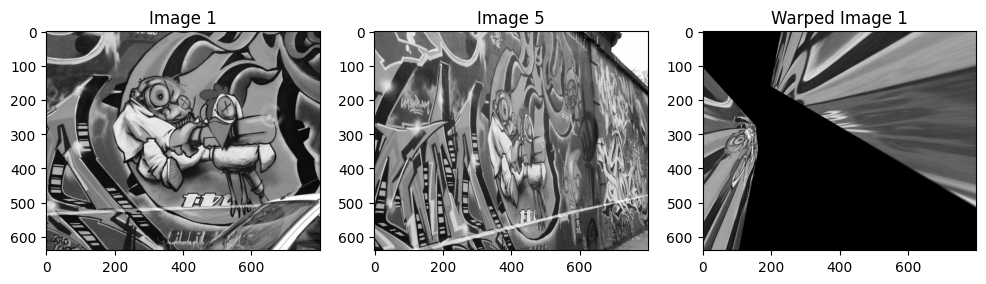

In [7]:

# Load the images
img1 = cv.imread('img1.ppm', cv.IMREAD_GRAYSCALE)
img5 = cv.imread('img5.ppm', cv.IMREAD_GRAYSCALE)

# Create SIFT detector
sift = cv.SIFT_create()

# Detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp5, des5 = sift.detectAndCompute(img5, None)

# Create a Brute-Force Matcher (BFMatcher)
bf = cv.BFMatcher()

# Match descriptors
matches = bf.knnMatch(des1, des5, k=2)

# Apply ratio test to get good matches
good = []
for m, n in matches:
    if m.distance < 0.75* n.distance:
        good.append(m)

# Initialize variables to keep track of the best homography
best_homography = None
best_inlier_count = 0

# Define the inlier threshold for RANSAC
inlier_threshold = 4# You can adjust this based on your dataset

# Convert source and destination points to homogeneous coordinates
src_points = np.float32([kp1[m.queryIdx].pt for m in good])
dst_points = np.float32([kp5[m.trainIdx].pt for m in good])
src_points_homogeneous = np.hstack((src_points, np.ones((src_points.shape[0], 1))))
dst_points_homogeneous = np.hstack((dst_points, np.ones((dst_points.shape[0], 1))))

# Define the number of iterations for RANSAC
num_iterations = 1000  # You can adjust this based on your dataset

for iteration in range(num_iterations):
    # Randomly select 4 point correspondences (4-point RANSAC)
    random_indices = np.random.choice(src_points.shape[0], 4, replace=False)
    src_sample = src_points_homogeneous[random_indices]
    dst_sample = dst_points_homogeneous[random_indices]

    # Build the A matrix for the DLT algorithm using the selected correspondences
    A = []
    for i in range(src_sample.shape[0]):
        x, y = src_sample[i, :2]
        x_prime, y_prime = dst_sample[i, :2]
        A.append([-x, -y, -1, 0, 0, 0, x * x_prime, y * x_prime, x_prime])
        A.append([0, 0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])
    A = np.array(A)

    # Perform singular value decomposition (SVD) on the A matrix
    U, S, Vt = np.linalg.svd(A)
    
    # Extract the homography matrix from the right singular vector (last column of Vt)
    H_candidate = Vt[-1, :].reshape(3, 3)
    
    # Normalize the homography matrix (optional, for numerical stability)
    H_candidate /= H_candidate[2, 2]
    
    # Calculate the transformed points using the computed homography
    transformed_points = np.dot(src_points_homogeneous, np.linalg.inv(H_candidate).T)
    
    # Calculate the Euclidean distance between transformed and actual destination points
    distances = np.linalg.norm(transformed_points - dst_points_homogeneous, axis=1)
    
    # Count inliers based on the threshold
    inlier_count = np.sum(distances < inlier_threshold)
    
    # Check if this is the best model so far
    if inlier_count > best_inlier_count:
        best_inlier_count = inlier_count
        best_homography = H_candidate

# After the loop, best_homography should contain the estimated homography
if best_homography is not None:
    print("Best Estimated Homography Matrix:")
    print(best_homography)
else:
    print("RANSAC did not find a good model.")

# Apply the estimated homography to warp img1 onto img5
if best_homography is not None:
    warped_img = cv.warpPerspective(img1, best_homography, (img5.shape[1], img5.shape[0]))
    
    # Display the result
    plt.figure(figsize=(12, 6))
    plt.subplot(131), plt.imshow(img1, cmap='gray'), plt.title('Image 1')
    plt.subplot(132), plt.imshow(img5, cmap='gray'), plt.title('Image 5')
    plt.subplot(133), plt.imshow(warped_img, cmap='gray'), plt.title('Warped Image 1')
    plt.show()


6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00

In [9]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

# Convert the image to grayscale
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
image_gray = np.float32(gray)
h, w = image_gray.shape

# Define a range of sigma values to create the scale-space representation
sigma_values = np.arange(1, 33, 0.1)
scale_space = np.zeros((h, w, len(sigma_values)))
for i, sigma in enumerate(sigma_values):
    #log_hw = 3 * np.max(sigma_values)
    log_hw = 3 * sigma
    X, Y = np.meshgrid(np.arange(-log_hw, log_hw + 1), np.arange(-log_hw, log_hw + 1))
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)
    # Calculate the Laplacian of the Gaussian filter
    log = 1 / (2 * np.pi * sigma**2) * (X**2 / (sigma**2) + Y**2 / (sigma**2) - 2) * np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    f_log = cv.filter2D(image_gray, -1, log)
    scale_space[:, :, i] = np.absolute(f_log)
    #scale_space[:, :, i] = f_log



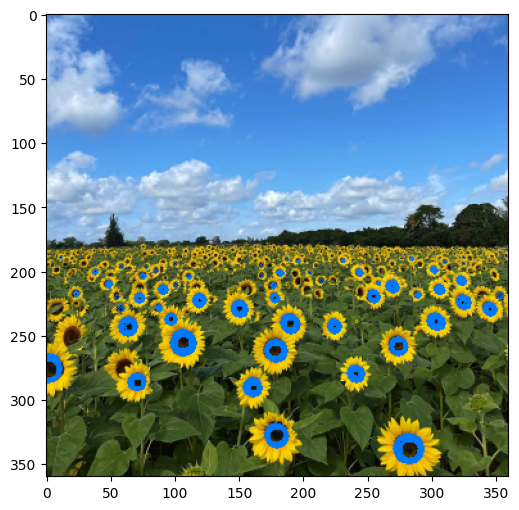

In [13]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
h, w, _ = image.shape
circle_mask = np.zeros((int(h),int(w)), dtype=np.uint8)

#scale_threshold = 0.79 * np.max(scale_space)
scale_thrshold=82.5

for i in range(h):
    for j in range(w):
        max_scale = np.max(scale_space[i, j, :])
        # Check if the maximum scale value at this location is above the threshold
        if max_scale > scale_threshold and circle_mask[i, j] == 0:
            # Calculate the corresponding scale value (sigma)
            scale_idx = np.argmax(scale_space[i, j, :])
            sigma = sigma_values[scale_idx]
            s = int((2**0.5) * sigma)
            
            # Draw a circle at this location
            cv.circle(image, (j, i), s, (0, 120, 250), 1)
            #cv.circle(circle_mask, (j, i), s, 1, -1)  
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()


In [11]:
indices = np.unravel_index(np.argmax(scale_space, axis=None), scale_space.shape)
print(np.max(scale_space)) # r = \sqrt{2}*sigma 
print(sigma_values[indices[2]])

102.1226577758789
2.5000000000000013


42.42640687119285


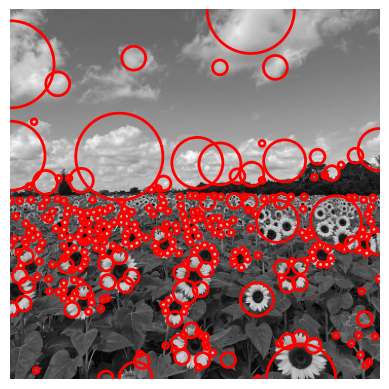

In [21]:
import skimage
from skimage.feature import blob_log
import math

image = cv.imread("the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

blobs_log = blob_log(gray_image, min_sigma=2, max_sigma=30, num_sigma=10, threshold=.1)
a = max(blobs_log[:, 2])
blobs_log[:, 2] = blobs_log[:, 2] * math.sqrt(2)
b = max(blobs_log[:, 2])

fig, ax = plt.subplots()
ax.imshow(gray_image, cmap='gray')
ax.axis('off')

for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

print(max(blobs_log[:, 2]))

plt.show()